<h1>Predicting game prices</h1>
<h5 style="margin-left: 2rem">By: Elad Ben-Haim, Shalev Hadar</h5>
<br/>
<br/>

<h4>נושא המחקר</h4>
<table dir="rtl">
    <tr>
        <th>
            נושא המחקר
        </th>
        <th>
            פירוט הנושא
        </th>
    </tr>
    <tr>
        <td>
        האם ניתן לחזות מחיר של משחק בעוד x זמן?
        </td>
        <td>
        מתי הכי ישתלם לקנות את המשחק בעתיד
        </td>
    </tr>
    <tr>
        <td>
        האם ניתן לחזור מתי למוכר הכי משתלם לעשות מבצע על המשחק?
        </td>
        <td>
        מתי הכי כדאי למוכר לעשות מבצע כדי להביא עוד שחקנים ולהמשיך למכור עם הרווח הגדול ביותר
        </td>
    </tr>
</table>
<br/>

<br/>

<h4>נתוני המחקר ודרכי ניתוח</h4>
<table dir="rtl">
    <tr>
        <th>
            נתוני המחקר & דרכי ניתוח
        </th>
        <th>
             ואיך ננתח אותם
        </th>
    </tr>
    <tr>
        <td>
		פירוט הנתונים: פרטים פיננסיים הוא נמכר בזמן X ואז לחזות בכמה הוא ימכר בזמן Y ובנוסף פרטים על המשחק - כמו שם, ז'אנר פופולריות וכו'.
        </td>
        <td>
            <p style="font-size: 1.1rem">
                נשתמש ב-Crawling על אתר isThereAnyDeal(Fig.3)<br/>
                כדי לא לקבל הודעת שגיאה על שימוש יתר, נשתמש ב-PROXY כדי לא להחסם ע"י isThereAnyDeal<br/>
                ונייבא משם את כל המידע הדרוש כדי לחזות את המחיר של משחק בעוד X זמן מסוים.<br/>
                ראינו שלכל משחק קיים באיזור ה1000+ (Fig.2) רשומות של log (Fig.1) של המחיר שלו ביחס לזמן, ולחנות בה הוא נמכר ואת העלייה\ירידה במחיר של המשחק ביחד ללוג הקודם.<br/>
                בעזרת STEAM API נוציא את ז'אנר המשחק, שנת הייצור ועוד פרטים מורכבים יותר על המשחק עצמו<br/>
                ולבסוף נצרף לכל לוג את פרטי המשחק ונקבל Dataset בגודל n = כמות המשחקים, x = כמות הלוגים, כלומר n*x<br/>
                אנחנו מעוניינים כרגע לקחת את 100 המשחקים הראשונים ולפי מה שראינו כמות הלוגים בדרך כלל היא לפחות 1000 אז נקבל בסביבות ה100,000+ רשומות.<br/>
            </p>
        </td>
    </tr>
    <tr>
        <td>
		דרכי ניתוח: נשתמש בכלים שלמדנו במהלך הקורס לעבד\ללמוד מהנתונים כמה מידע שאנו צריכים למטרה זו
        </td>
        <td>
            <p style="font-size: 1.1rem">
                ננתח את הDataFrame, בעזרת טבלאות יחסי משתנים, סטטיסטיקות, ולבסוף ננסה ללמד מכונה שתחזה את התאריך של המחיר הזול ביותר בשנה מסוימת, ואת המחיר אשר יביא את כמות המכירות הגדול ביותר
            </p>
        </td>
    </tr>
</table>
<br/>
<table style="width:100%;grid-template-rows: 1fr 1fr 1fr;">
<tr>
    <td>
        <figure>
            <img src="images\log_table_for_ds3.png" alt="Is there any deal log table">
            <figcaption>Fig.1 - The main crawled data source</figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images\number_of_logs_for_ds3.png" alt="Example for number of rows in a typical game">
            <figcaption>Fig.2 - Example for number of rows in a typical game (Dark souls 3) </figcaption>
        </figure>
    </td>
    <td>
        <figure>
            <img src="images\is_there_any_deal_site_example_ds3.png" alt="Is there any deal game page">
            <figcaption>Fig.3 - IsThereAnyDeal game page</figcaption>
        </figure>
    </td>
</tr>

<h4>Importing</h6>

In [61]:
import requests
import bs4
from bs4 import BeautifulSoup
import random
import itertools
import re
import pandas as pd
from pandas import DataFrame
import time
import datetime
import locale
import os.path
import json
import ast
import dateutil.parser
from deep_translator import GoogleTranslator
import pickle
import seaborn as sns
from collections import OrderedDict
import matplotlib as plt
from matplotlib import pyplot
import numpy as np

<h4>Global functions</h4>

In [44]:
class list(list):
    def filter(self, fn):
        return list(filter(fn, self))
    def map(self, fn):
        return list(map(fn, self))
    def forEach(self, fn):
        for i in self.__iter__():
            fn(i)

def get_html_response(url: str, proxy: str = None, params: list = None) -> requests.Response:
    time.sleep(1)
    if proxy is not None:
        return requests.get(url, proxies={"http": proxy, "https":proxy}, params=params)
    else:
        return requests.get(url, params=params)

def get_response_as_beautiful_soup(req: requests.Response) -> BeautifulSoup:
    return BeautifulSoup(req.text, 'html.parser')

def cache_json(folder_path: str, id: str, get_function):
    if os.path.isfile(f'{folder_path}/{id}.json'):
        f = open(f'{folder_path}/{id}.json', 'r')
        data = json.load(f)
        f.close()
    else:
        data = get_function(id).json()
        f = open(f'{folder_path}/{id}.json', 'a')
        f.write(json.dumps(data))
        f.close()
    return data

def cache_soup(folder_path: str, id: str, get_function):
    if os.path.isfile(f'{folder_path}/{id}.html'):
        f = open(f'{folder_path}/{id}.html', 'r')
        soup = BeautifulSoup(f.read(), 'html.parser')
        f.close()
    else:
        res = get_function(id)
        f = open(f'{folder_path}/{id}.html', 'a')
        f.write(res.text)
        f.close()
        soup = get_response_as_beautiful_soup(res)
    return soup

def translate(source: str):
    url = 'translations.pickle'
    translations = dict()
    if os.path.isfile(url):
        f = open(url, "rb")
        translations = pickle.load(f)
        f.close()
    
    translation = translations.get(source)
    if translation is not None:
        return translation

    translator = GoogleTranslator(source='auto', target='en')
    translation = translator.translate(source)
    translations[source] = translation
    f = open( url, "wb" )
    pickle.dump(translations, f)
    f.close()
    return translation

def get_len(col):
    if type(col) is list:
        return len(col)
    else:
        return 0

def pluck(key):
    return lambda col: col.get(key) if type(col) is dict else None

def pluckBy(key, okFunction = lambda val: val, errFunction = lambda _: None):
    return lambda col: okFunction(col.get(key)) if type(col) is dict else errFunction(None)

def parse_datetime(datetime_str: str):
    try:
        return dateutil.parser.parse(datetime_str)
    except:
        return dateutil.parser.parse(translate(datetime_str))

def truncate(text: str, max_num_of_letters: int):
    if len(text) > max_num_of_letters:
        return f'{text[:max_num_of_letters]}...'
    else:
        return text

<br/>

<h4>Defining proxies for scraping</h4>

<h5>Get proxy list response html website</h5>
<h6>get the html as response object instead of getting the html again and again</h6>

In [3]:
# Get the html of the proxy list website
def get_proxy_list_html() -> requests.Response:
    # Website to get free proxies
    return get_html_response('https://free-proxy-list.net/')

In [4]:
proxies_response = get_proxy_list_html()

<h5>Scrape proxy ip addresses</h5>
<h6>gets the ip addresses as a list, shuffles them and returns an iterator to cycle through when making scrape requests</h6>

In [5]:
def get_proxy_list() -> itertools.cycle:
    soup = get_response_as_beautiful_soup(proxies_response)
    proxy_soup_list = soup.select('#list > div > div.table-responsive > div > table > tbody > tr')
    proxy_list = list(map(lambda i: i.select('td:nth-child(1)')[0].text + ':' + i.select('td:nth-child(2)')[0].text, proxy_soup_list))
    length = len(proxy_list)
    random.shuffle(proxy_list)
    return itertools.cycle(proxy_list), length

In [6]:
proxy_list, proxy_list_length = get_proxy_list()
current_proxy = next(proxy_list)

In [7]:
def get_proxied(url: str, params: list = None) -> requests.Response:
    i = 0
    while(i < proxy_list_length / 2):
        try:
            response = get_html_response(url, current_proxy, params=params)
            time.sleep(2)
            return response
        except:
            i += 1
        finally:
            current_proxy = next(proxy_list)

    raise RuntimeError('Half of the proxies provided don`t work.')

<br/>

<h2>Crawling + Analyzing</h2>

<h4>Scrape isThereAnyDeal website</h4>
<h6>Steps:</h6>
<ol>
<li>Crawl list of top 100 trending games</li>
<li>For each game:</li>
<ul>
    <li>get the game details from steam API using "appId" scraped either from PC Gaming Wiki or Steam Ladder links</li>
    <li>mine price Log history on isThereAnyDeal</li>
    <li>mine Number of sales of the game</li>
<ul>
</ol>

In [8]:
is_there_any_deal_url = 'https://isthereanydeal.com'
steam_api_url = 'https://store.steampowered.com/api/appdetails'

<h5>Get list of 100 top trending games</h5>

In [9]:
def get_is_there_any_deal_games_response() -> requests.Response:
    filteredUrl = 'https://isthereanydeal.com/'
    return get_html_response(filteredUrl)

In [10]:
is_there_any_deal_games_response = get_is_there_any_deal_games_response()
print(is_there_any_deal_games_response)

<Response [200]>


In [11]:
def add_game_to_dataframe(df: DataFrame, game: dict) -> DataFrame:
    return df.append(DataFrame([game]), ignore_index=True)

In [12]:
def get_steam_api_game_response(steamId: str) -> requests.Response:
    return get_html_response(steam_api_url, params={'appids': steamId})

In [13]:
def delete_if_exists(d: dict, *keys: list) -> dict:
    for key in keys:
        if d.get(key) is not None:
            del d[key]
    return d

In [14]:
def get_steam_api_game_details(steamId: str) -> dict:
    data = cache_json('steam_api_details', steamId, get_steam_api_game_response)
    if data.get(steamId) is None or data.get(steamId).get('data') is None:
        return {}
    data = data[steamId]['data']

    if data.get('categories') is not None: # GAME ,,,,, [{id:3, name: ACTION}, {id:5, name:ROUGE_LIKE}]
        for category in data['categories']:
            data['category.'+str(category['id'])]=True
        del data['categories']
    
    if data.get('genres') is not None:
        for genre in data['genres']:
            data['genre.'+str(genre['description'])]=True
        del data['genres']
    
    if data.get('developers') is not None:
        for developer in data['developers']:
            data[f'developer.' + developer.strip().replace(' ', '_')]=True
        del data['developers']
    
    if data.get('publishers') is not None:
        for publisher in data['publishers']:
            data[f'publisher.' + publisher.strip().replace(' ', '_')]=True
        del data['publishers']
        
    if data.get('supported_languages') is not None: # <strong>*</strong>English<strong>*</strong>, Japanese, Spanish => ['English', 'Japanese', 'Spanish']
        for language in data['supported_languages']\
                            .replace('<strong>*</strong>', '')\
                            .replace('<br/>', '')\
                            .replace('<br>', '')\
                            .replace('languages with full audio support', '')\
                            .split(','):
            data[f'supported_language.' + language.strip().replace(' ', '_')]=True
        del data['supported_languages']

    return data

<img style="width: 50%" src="images/steam_api_response.png"/>

In [15]:
def get_game_dataframe():
    soup = get_response_as_beautiful_soup(is_there_any_deal_games_response)
    df = DataFrame()
    games = soup.select("#games > div.game")
    game_dict = dict()
    for game in games:
        steamId = game.attrs.get('data-steamid')
        if steamId is not None:
            steamId: str
            if 'app' in steamId:
                steamId = steamId.split('/')[1] # app/{steamId}
                title = game.select("div.title > a")[0].text
                history = game.select("div.overview.exp.tgl-hide > a:nth-child(5)")[0].attrs.get('href')
                game_details = get_steam_api_game_details(steamId)
                if game_details == {}: continue
                df = add_game_to_dataframe(df, {'steamId': steamId, 'title': title, 'history_link': is_there_any_deal_url + history, **game_details})
    return df

In [16]:
games_dataframe = get_game_dataframe()
games_dataframe.to_csv('games_dataframe.csv')
games_dataframe

,steamId,title,history_link,type,name,steam_appid,required_age,is_free,controller_support,detailed_description,...,publisher.Team_Cherry,developer.TaleWorlds_Entertainment,publisher.TaleWorlds_Entertainment,developer.Turtle_Rock_Studios,publisher.Warner_Bros._Games,publisher.Warner_Bros._Interactive_Entertainment,publisher.Feral_Interactive,developer.Christian_Whitehead,developer.Headcannon,developer.PagodaWest_Games
0,1285040,D-Corp,https://isthereanydeal.com/game/dcorp/history/,game,D-Corp,1285040,0,False,full,<h1>Join the Discord community!</h1><p><a href...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1174180,Red Dead Redemption 2,https://isthereanydeal.com/game/reddeadredempt...,game,Red Dead Redemption 2,1174180,0,False,NaN,"<h1>Ultimate Edition</h1><p><img src=""https://...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,807120,Iratus: Lord of the Dead,https://isthereanydeal.com/game/iratuslordofde...,game,Iratus: Lord of the Dead,807120,0,False,NaN,"<h1>Featured DLC</h1><p><a href=""https://store...",...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1091500,Cyberpunk 2077,https://isthereanydeal.com/game/cyberpunkii0vi...,game,Cyberpunk 2077,1091500,18,False,NaN,<h1>Check out other games from CD PROJEKT RED<...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1151640,Horizon Zero Dawn™ Complete Edition,https://isthereanydeal.com/game/horizonzerodaw...,game,Horizon Zero Dawn™ Complete Edition,1151640,16,False,full,EARTH IS OURS NO MORE<br />\r\n<br />\r\nExper...,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77,367520,Hollow Knight,https://isthereanydeal.com/game/hollowknight/h...,game,Hollow Knight,367520,0,False,full,"<h2 class=""bb_tag"">Hollow Knight Expands with ...",...,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
78,261550,Mount & Blade II: Bannerlord,https://isthereanydeal.com/game/mountandbladei...,game,Mount & Blade II: Bannerlord,261550,0,False,NaN,"<img src=""https://cdn.cloudflare.steamstatic.c...",...,NaN,True,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN
79,924970,Back 4 Blood,https://isthereanydeal.com/game/backivblood/hi...,game,Back 4 Blood,924970,18,False,full,<h1>Back 4 Blood: Deluxe Edition</h1><p><img s...,...,NaN,NaN,NaN,True,True,True,NaN,NaN,NaN,NaN
80,1142710,Total War: WARHAMMER III,https://isthereanydeal.com/game/totalwarwarham...,game,Total War: WARHAMMER III,1142710,0,False,NaN,"<h1>Join Our Discord Server</h1><p><a href=""ht...",...,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN


In [17]:
games_dataframe = pd.read_csv('./games_dataframe.csv')

In [18]:
def drop_columns(df: DataFrame, columns) -> DataFrame:
    return df.drop(columns, axis=1)

def use_val(fun):
    return lambda col: fun(ast.literal_eval(col)) if type(col) is str else fun(col)


In [19]:

def map_steam_api_game_data(ndf: DataFrame) -> DataFrame:
    df = ndf.copy()
    ignored_columns = [
        'type',
        'name',
        'steam_appid',
        'detailed_description',
        'about_the_game',
        'short_description',
        # 'fullgame',
        'header_image',
        'website',
        'pc_requirements',
        'mac_requirements',
        'linux_requirements',
        'legal_notice',
        'price_overview',
        'package_groups',
        'screenshots',
        'achievements',
        'background',
        'content_descriptors',
        'support_info',
        'ext_user_account_notice',
        'reviews',
        'drm_notice'
    ]
    df = drop_columns(df, ignored_columns)

    for (new_col, col) in (('number_of_demos', 'demos'), ('num_of_game_videos', 'movies'), ('num_of_dlc', 'dlc'), ('num_of_packages_game_is_in', 'packages')):
        df[new_col] = df[col].apply(use_val(get_len))
        df = drop_columns(df, col)

    df['metacritic_score'] = df['metacritic'].apply(use_val(pluckBy('score', lambda score: score / 100)))
    df = drop_columns(df, 'metacritic')

    for (new_col, col, key) in (('windows_supported', 'platforms', 'windows'), ('mac_supported', 'platforms', 'mac'), ('linux_supported', 'platforms', 'linux')):
        df[new_col] = df[col].apply(use_val(pluckBy(key, lambda val: val == True, lambda _: False)))
    df = drop_columns(df, 'platforms')
    
    df['total_steam_recommendations'] = df['recommendations'].apply(use_val(pluck('total')))
    df = drop_columns(df, 'recommendations')

    df['release_date'] = df['release_date'].apply(use_val(pluckBy('date', parse_datetime)))

    for col in filter(lambda c: len(c.split('.')) > 1,df.columns):
        df[col].fillna(False, inplace=True)
    return df

In [20]:
games_dataframe2 = map_steam_api_game_data(games_dataframe)
games_dataframe2.to_csv('games_details_data.csv')

<h5>Get price history for each game</h5>

In [21]:
pounds_to_usd_conversion_rate = 1.34

In [22]:
def convert_to_usd(price: str) -> float:
    parsed_price = float(re.sub('\$|\£|\s','',price).strip().lstrip())
    
    if ('£' in price):
        parsed_price = parsed_price * pounds_to_usd_conversion_rate

    return parsed_price

In [23]:
def get_game_history_details(steamId: str, history_link: str) -> DataFrame:
    soup = cache_soup('games', steamId, lambda x: get_html_response(history_link))
    
    df = DataFrame()
    vals = soup.select("div.lg2.game")
    for val in vals:
        dateText = val.select_one("span.lg2__time-rel").attrs['title']
        date = datetime.datetime.strptime(dateText, '%a, %d %b %Y %H:%M:%S +0000')
        shop_title = val.select_one('.shopTitle').text.strip()
        regular_price_text = val.select_one('div:nth-child(2) > span.lg2__price').text
        price_now_text = val.select_one('div:nth-child(3) > span.lg2__price').text
        regular_price = convert_to_usd(regular_price_text)
        price_now = convert_to_usd(price_now_text)

        if (regular_price != 0):
            price_change_percentage = price_now / regular_price
        else:
            price_change_percentage = 0
        df = df.append(DataFrame([{'record_date': date, 'shop': shop_title, 'regular_price': regular_price, 'price_now': price_now, 'price_change': price_change_percentage}]))
    return df


In [24]:
def get_games_with_history():
    games_with_history = DataFrame()
    for index, row in games_dataframe2.iterrows():
        row_df = DataFrame([row])
        game_history_details = get_game_history_details(row['steamId'], row['history_link'])

        game_history_details['key'] = 1
        row_df['key'] = 1

        cross = row_df.merge(game_history_details, how = 'outer')
        games_with_history = games_with_history.append(cross)
    
    games_with_history.dropna(subset=['shop', 'regular_price'], inplace=True)
    return games_with_history

In [25]:
games_with_history = get_games_with_history()

In [26]:
def clean_game_history_details(ndf: DataFrame) -> DataFrame:
    df = ndf.copy()
    if (df.get('shop') is not None):
        df.drop(df[df['shop']=='voidu'].index, inplace=True)
        df.drop(df[df['shop']=='Voidu'].index, inplace=True)
    if (df.get('regular_price') is not None):
        df.drop(df[df['regular_price'] == 0].index, inplace=True)

    df['controller_support'].fillna('no', inplace=True)
    df.drop(['Unnamed: 0'], axis=1, inplace=True)
    df.drop(['key'], axis=1, inplace=True)
    return df

In [27]:
cleaned_games_with_history = clean_game_history_details(games_with_history)

In [28]:
cleaned_games_with_history.to_csv('games_with_history.csv')

<h2>Exploratory Data Analysis</h2>

In [29]:
pie_chart_size = 10

<h5>Functions</h5>

In [41]:
def get_frequent_elements(df: DataFrame, col_name: str, num_top_elements: int) -> pd.Series:
    return pd.Series(df[col_name].value_counts()[:num_top_elements].sort_index())

def one_dim_plot(sr: pd.Series, plot_type: str, axis: int = None):
    sr.plot(kind=plot_type, ax=axis, autopct='%1.0f%%', pctdistance=1.1, labeldistance=1.2)

def plot_scatter(df: DataFrame, x: str, y: str):
    sns.lmplot(x=x,y=y,data=df,fit_reg=True)

def plot_line(df: DataFrame, x: str, y: str):
    df.plot.line(x=x, y=y)

def plot_frequency(df: DataFrame, col: str, axis=None, num_of_charts=1):
    elm = get_frequent_elements(df, col, 5)
    plt.rcParams['figure.figsize'] = (pie_chart_size*num_of_charts, pie_chart_size)
    if (axis):
        one_dim_plot(elm, 'pie', axis)
    else:
        one_dim_plot(elm, 'pie')

def plot_bar_chart(df: DataFrame, sizeX: int = None, sizeY: int = None):
    if sizeX and sizeY:
        plt.rcParams['figure.figsize'] = (sizeX, sizeY)
    df.plot.bar(rot=0)

def plot_pie_remove_duplicates(df: DataFrame, key: str, axis=None, num_of_charts=1):
    plot_df = df.copy()

    # we need to drop the repeating games (because we want the real average)
    plot_df.drop_duplicates(subset=['steamId'], inplace=True)
    plot_frequency(plot_df, key, axis=axis, num_of_charts=num_of_charts)

def plot_game_price_history(df: DataFrame, steam_id: int, game_title: str, year: int = None, show_holidays = False):
    data = df.copy().filter(['steamId', 'record_date', 'price_change'], axis=1)
    data['price_change'] = 1 - data['price_change']
    data = data[data['steamId'] == steam_id]
    data['record_date'] = pd.to_datetime(data['record_date'], format='%Y-%m-%d %H:%M:%S')
    if year is not None:
        from_date = datetime.datetime(year, 1, 1)
        to_date = datetime.datetime(year+1, 1, 1)
        data = data[data['record_date'] > from_date]
        data = data[data['record_date'] < to_date]
    data.drop('steamId', axis=1, inplace=True)
    data = data.set_index('record_date')
    least_date: datetime.datetime = data.index.min()
    most_date: datetime.datetime = data.index.max()
    holidays = [('Christmas', 12, 25),\
                ('Black Friday', 11, 25),\
                ('Chinese Single\'s Day', 11, 11),\
                ('Steam Summer Sale', 10, 1)]

    data.plot(title=(f'{game_title}, year {year}' if year is not None else game_title)) # Shadow of the tomb raider, year 2017
    if show_holidays:
        for (holiday, month, day) in holidays:
            for i in range (least_date.year, most_date.year + 1):
                pyplot.axvline(x=datetime.datetime(i, month, day),color='m', linestyle="--")
                pyplot.text(datetime.datetime(i, month, day),0,holiday,rotation=90)


def get_n_games_row_count(df: DataFrame, n: int) -> list:
    games = dict(df['steamId'].value_counts().sort_values(ascending=False)[:n])
    games_list = list()
    for (steam_id, count) in games.items():
        games_list.append((steam_id, df[df['steamId']==steam_id].iloc[0]['title'], count))
    return games_list

def plot_regular_price_per_genre(df: DataFrame):
    data = df.copy()
    genre_colums = list(data.columns).filter(lambda x: str(x).startswith('genre.'))
    genre_averages = dict()
    for genre_colum in genre_colums:
        genre_averages[genre_colum] = df[df[genre_colum]==True]['regular_price'].mean() # Average regular price for all rows matching the genre
    averages = list(genre_averages.items())
    averages = sorted(averages, key=lambda k: k[1], reverse=True)
    keys = list(map(lambda item: truncate(item[0].split('.')[1], 10), averages))
    values = list(map(lambda item: item[1], averages))
    plot_bar_chart(DataFrame(values, keys), sizeX=30, sizeY=5)

# Plot out top 5 publishers
# drop duplicate games by steamId
# group by publisher
# select row from publisher
# calculate average price per publisher (sum of regular price divided by the number of games)
# present as bar graph
def plot_average_per_top_5_publisher(df: DataFrame):
    # we need to drop the repeating games (because we want the real average)
    plot_df = df.copy().drop_duplicates(subset=['steamId'])

    publisher_and_average = dict() # {'publisher.mashu': 33.4, 'publisher.fds': 45.5}
    for col in filter(lambda x: str(x).startswith('publisher.'), plot_df.columns):
        publisher_games = plot_df[plot_df[col] == True]
        num_of_games = len(publisher_games.index)
        publisher_and_average[col] = {
            'avg': publisher_games.regular_price.mean(),
            'games_num': num_of_games
        }
    
    top_5_publishers = OrderedDict(sorted(publisher_and_average.items(), key=lambda item: item[1]['games_num'], reverse=True))
    top_5_vals = map(lambda x: x['avg'], list(top_5_publishers.values())[:5])
    top_5_keys = map(lambda x: x.split('.')[1].replace('_', ' '), list(top_5_publishers.keys())[:5])
    plot_bar_chart(DataFrame(top_5_vals, top_5_keys), sizeX=15, sizeY=5)

<h3>Most frequent shop</h3>

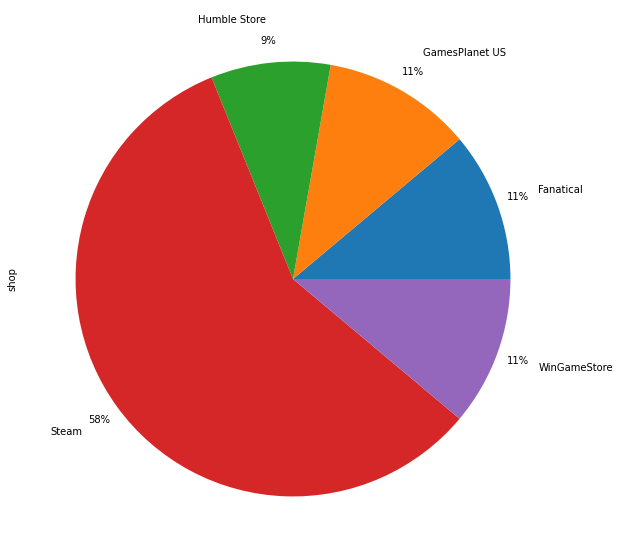

In [45]:
plot_pie_remove_duplicates(df=cleaned_games_with_history, key='shop')

<h3>Metacritic score per total steam recommendations</h3>
<p>
We can see that more steam recommendations do infact infer a better Metacritic score,
<br/>There is definitely a linear dependency between them
</p>

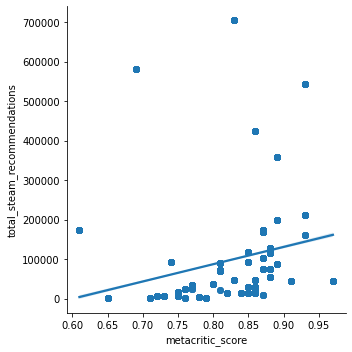

In [46]:
plot_scatter(cleaned_games_with_history, 'metacritic_score', 'total_steam_recommendations')

<h3>Regular Price / Number of dlcs available</h3>
We can see that when the price is between 20 and 80 dollars the games have more dlcs

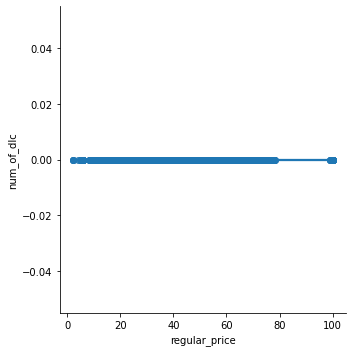

In [47]:
plot_scatter(cleaned_games_with_history, 'regular_price', 'num_of_dlc')

<h3>Metacric score / Regular Price</h3>
<p>We can see that the regular price is often lined to the metacritic score the game got.</p>

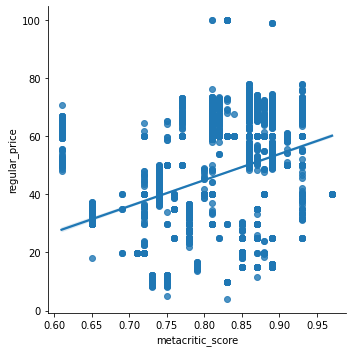

In [48]:
plot_scatter(cleaned_games_with_history, 'metacritic_score', 'regular_price')

<h3>Game Price / Publisher</h3>
<p>We can see that the most expensive publishers are big companys</p>

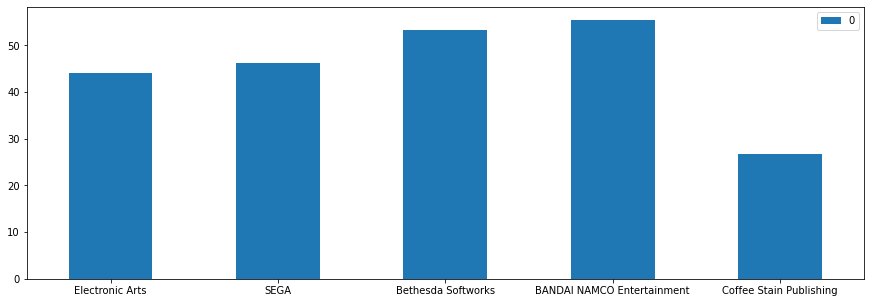

In [49]:
plot_average_per_top_5_publisher(cleaned_games_with_history)

<h3>Regular price / Genre</h3>
<p>
We can see that the genres Action, adventure and RPG average cost is higher <br/>
probably because the development takes far more time for these genres
</p>

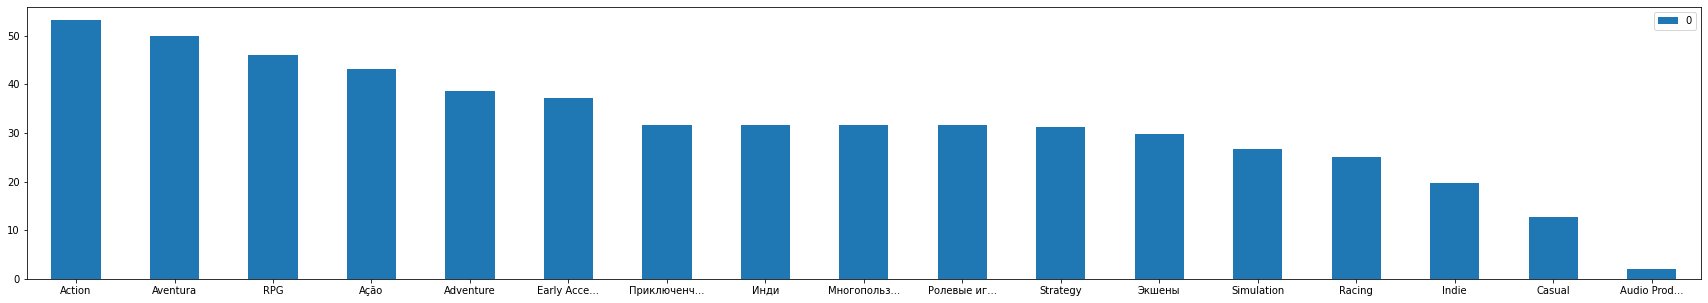

In [50]:
plot_regular_price_per_genre(cleaned_games_with_history)

<h3>Controller support Pie chart</h3>

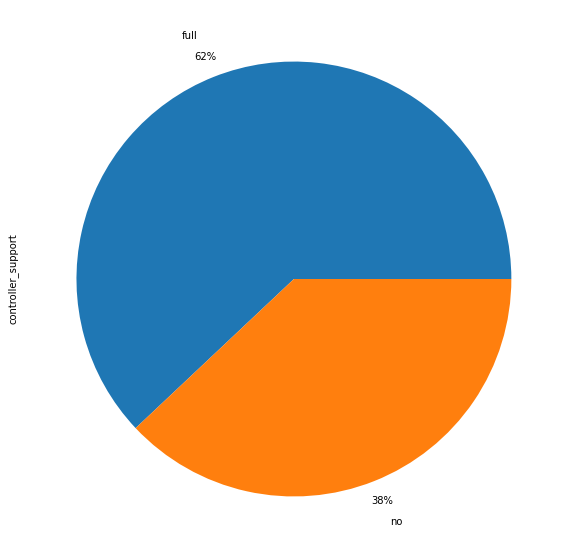

In [51]:
plot_pie_remove_duplicates(cleaned_games_with_history, 'controller_support')

<h3>Platforms supported Pie chart</h3>
<p>We can see that probably platforms that support Mac also support Linux, and all games support Windows</p>

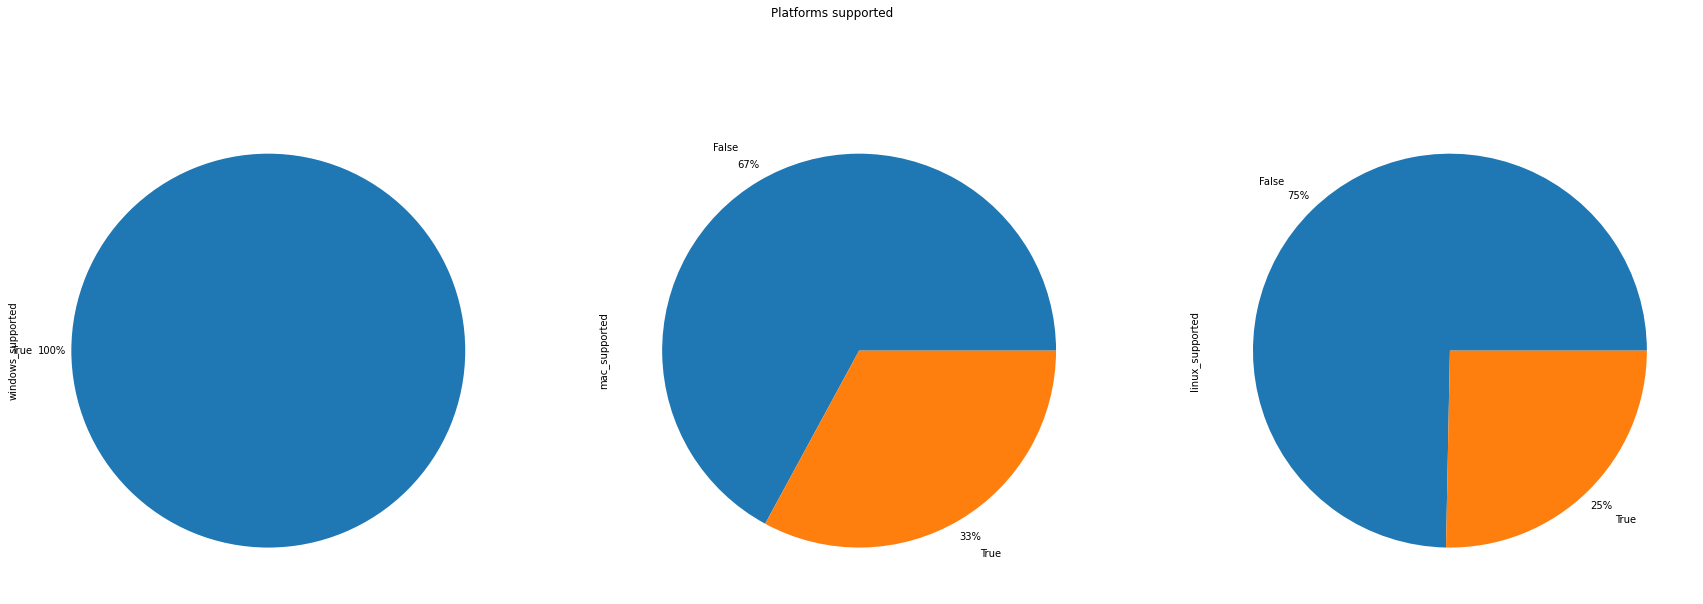

In [52]:
fig, (ax1, ax2, ax3) = plt.pyplot.subplots(1, 3)
fig.suptitle('Platforms supported')
fig.set_size_inches(pie_chart_size*3, pie_chart_size)

plot_pie_remove_duplicates(cleaned_games_with_history, 'windows_supported', ax1, num_of_charts=3)
plot_pie_remove_duplicates(cleaned_games_with_history, 'mac_supported', ax2, num_of_charts=3)
plot_pie_remove_duplicates(cleaned_games_with_history, 'linux_supported', ax3, num_of_charts=3)

<h3>Sales of 5 top games over time (the ones which have most history)</h3>
<p>We can see that most games start giving discounts of more than 20% after the first year of release,<br/>
then reach 50% on the start of the next year and on the third and fourth reach a max of 80% discount</p>

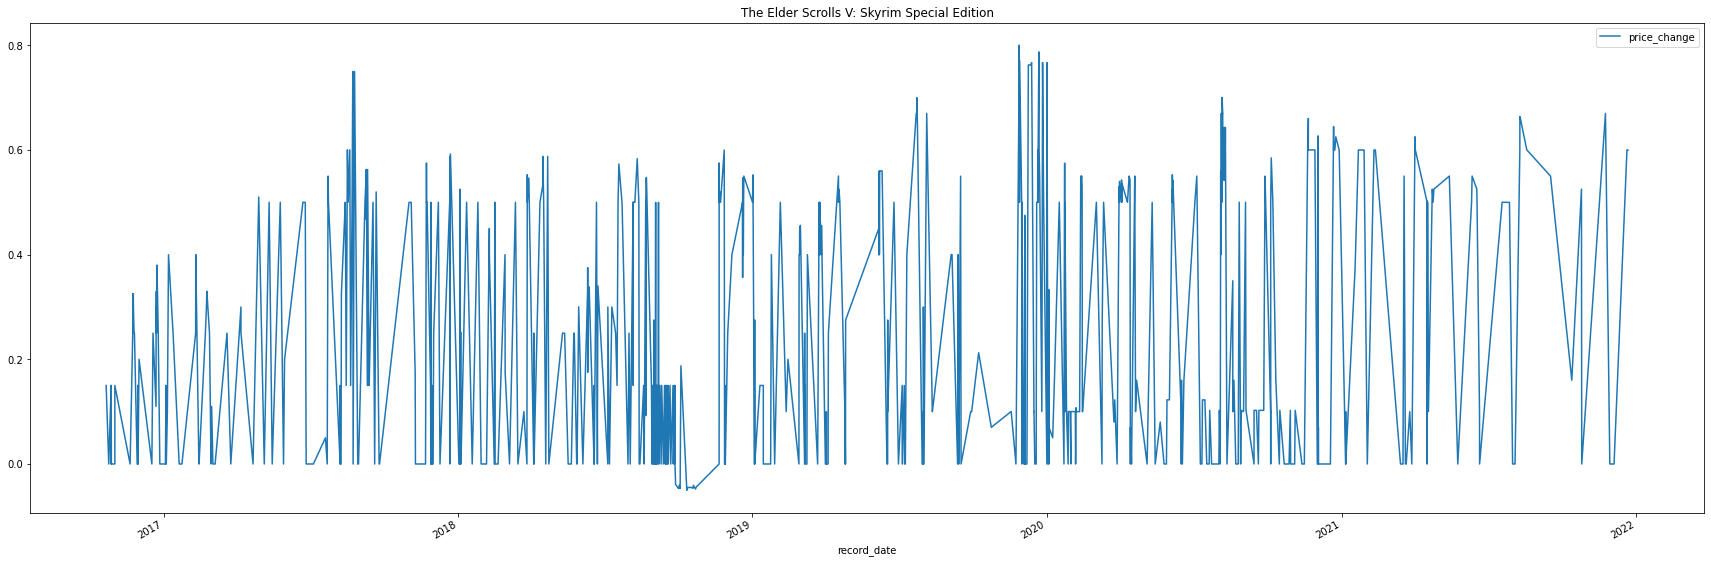

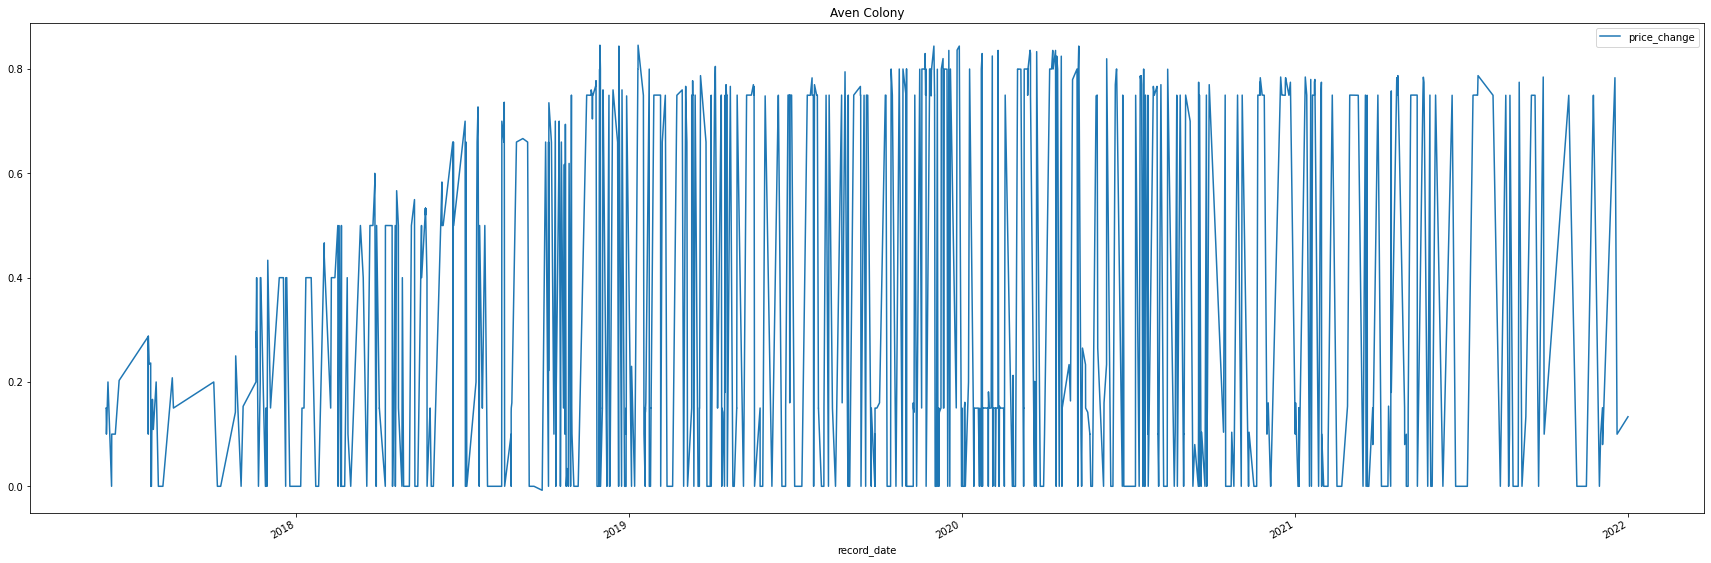

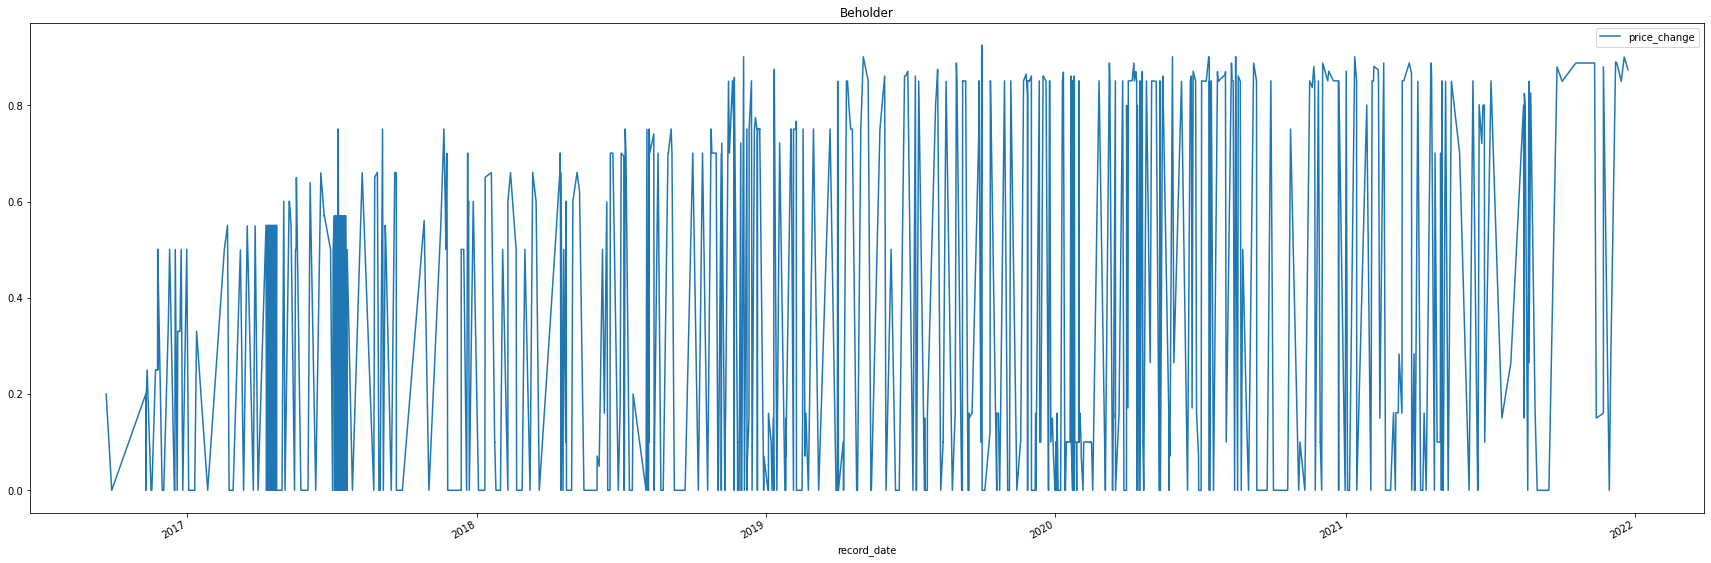

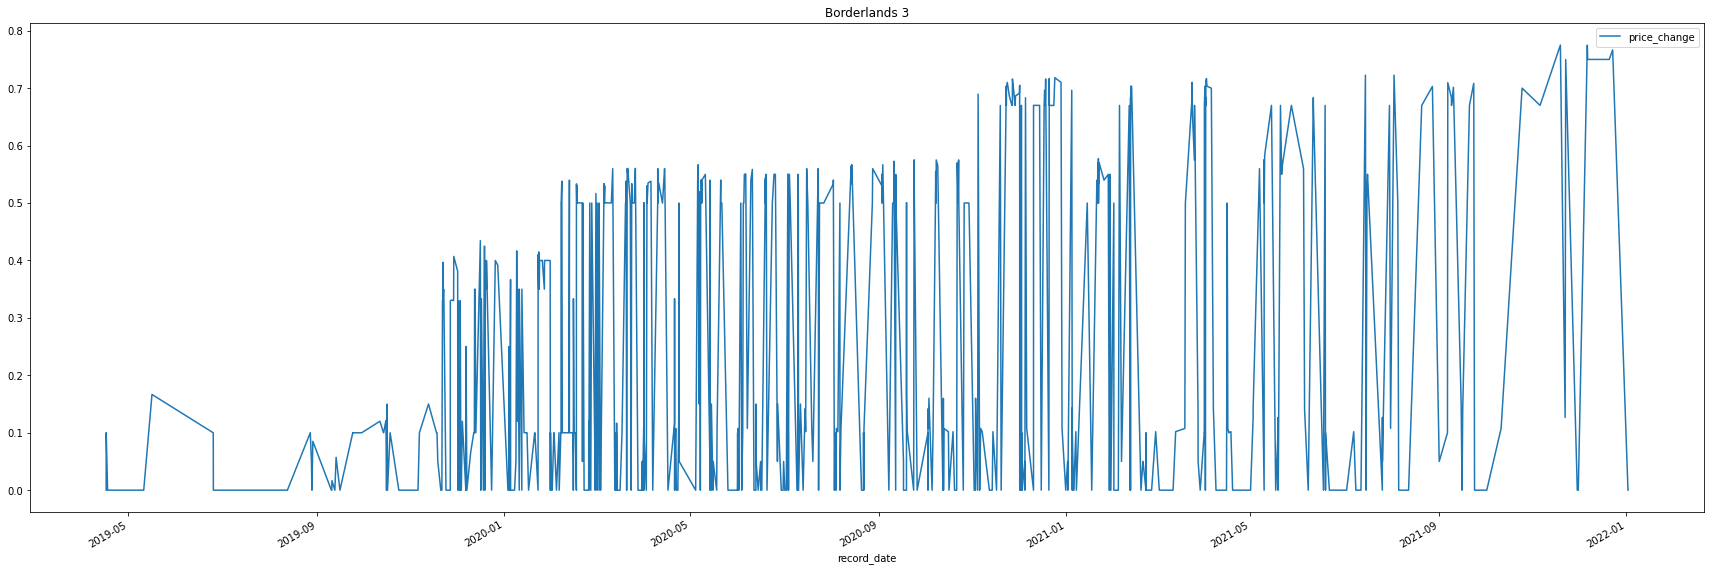

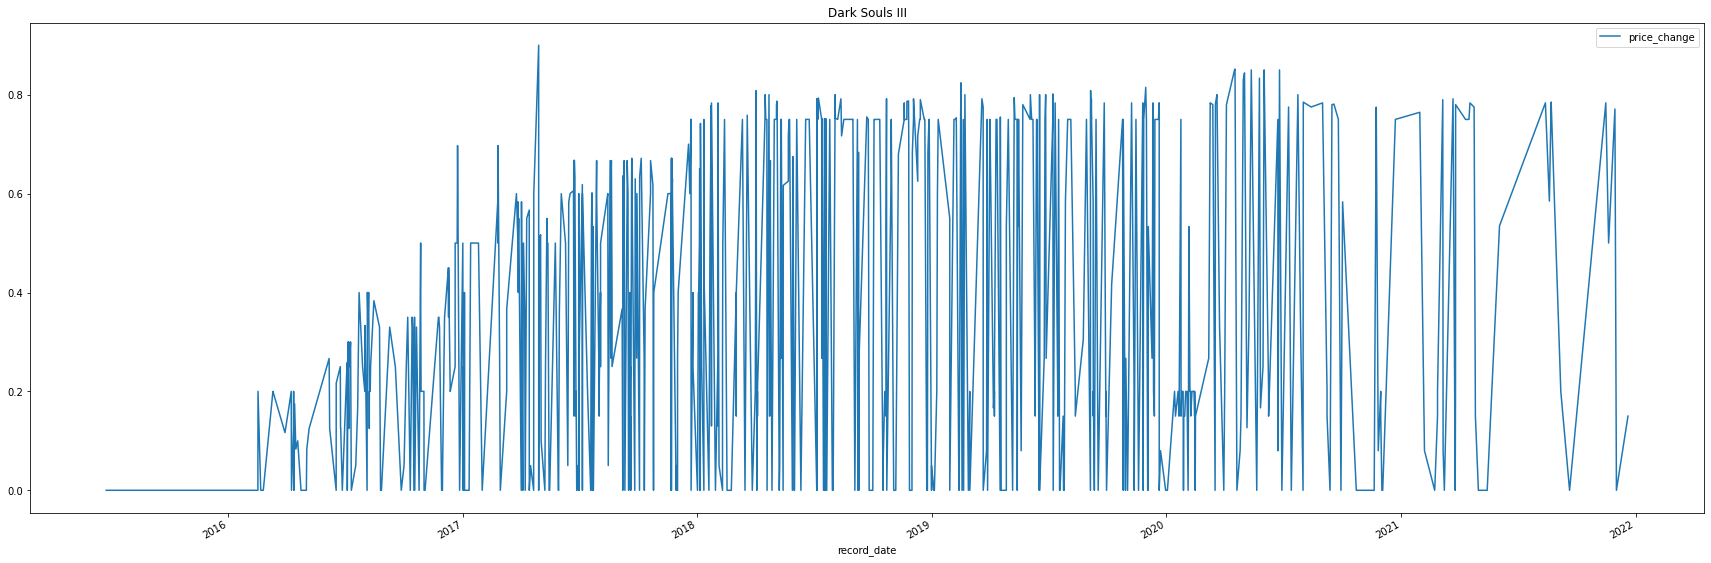

In [53]:
games = get_n_games_row_count(cleaned_games_with_history, 5)
for (steam_id, game_title, _) in games:
    plot_game_price_history(cleaned_games_with_history, steam_id, game_title=game_title)

<h3>Price drop of the top over a year with holidays in mind</h3>
<p>We also see that on holidays the prices of games drop substantially,<br/>
but like in the last Plot after the second year, the time of year is not a factor anymore
</p>

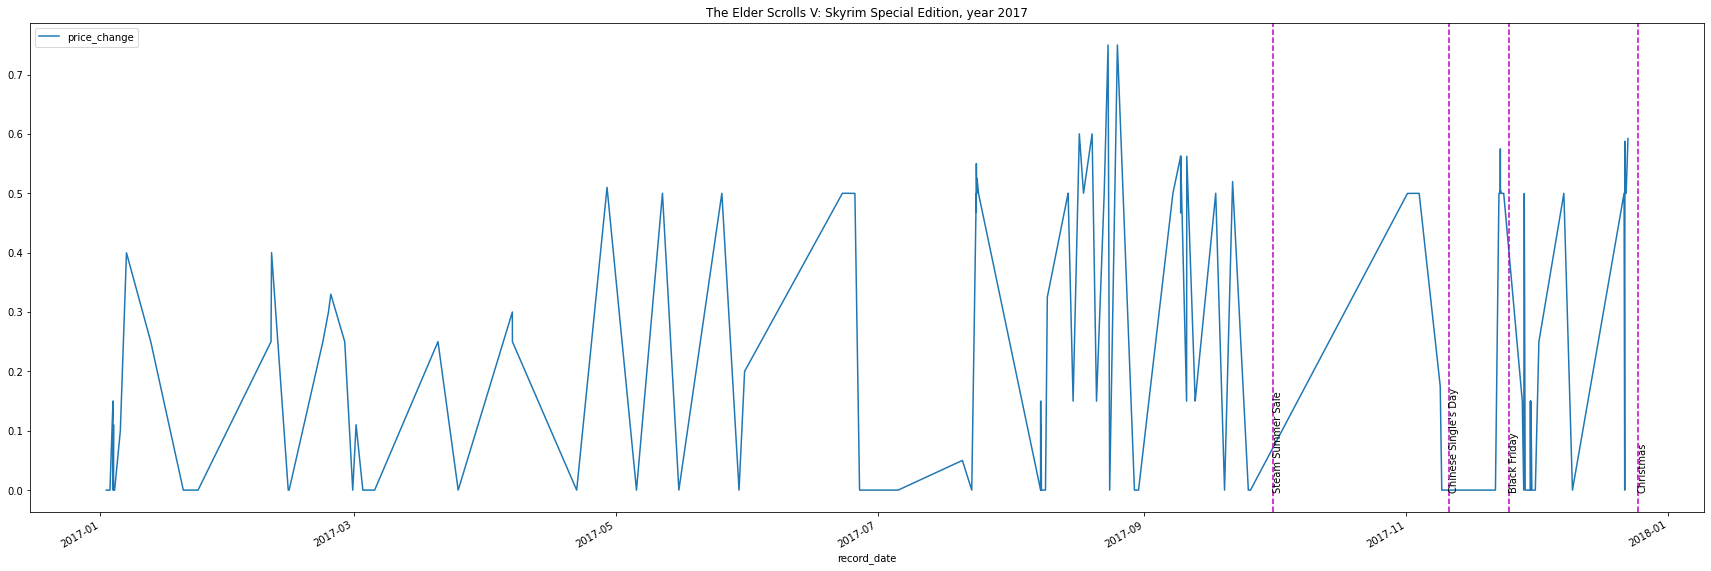

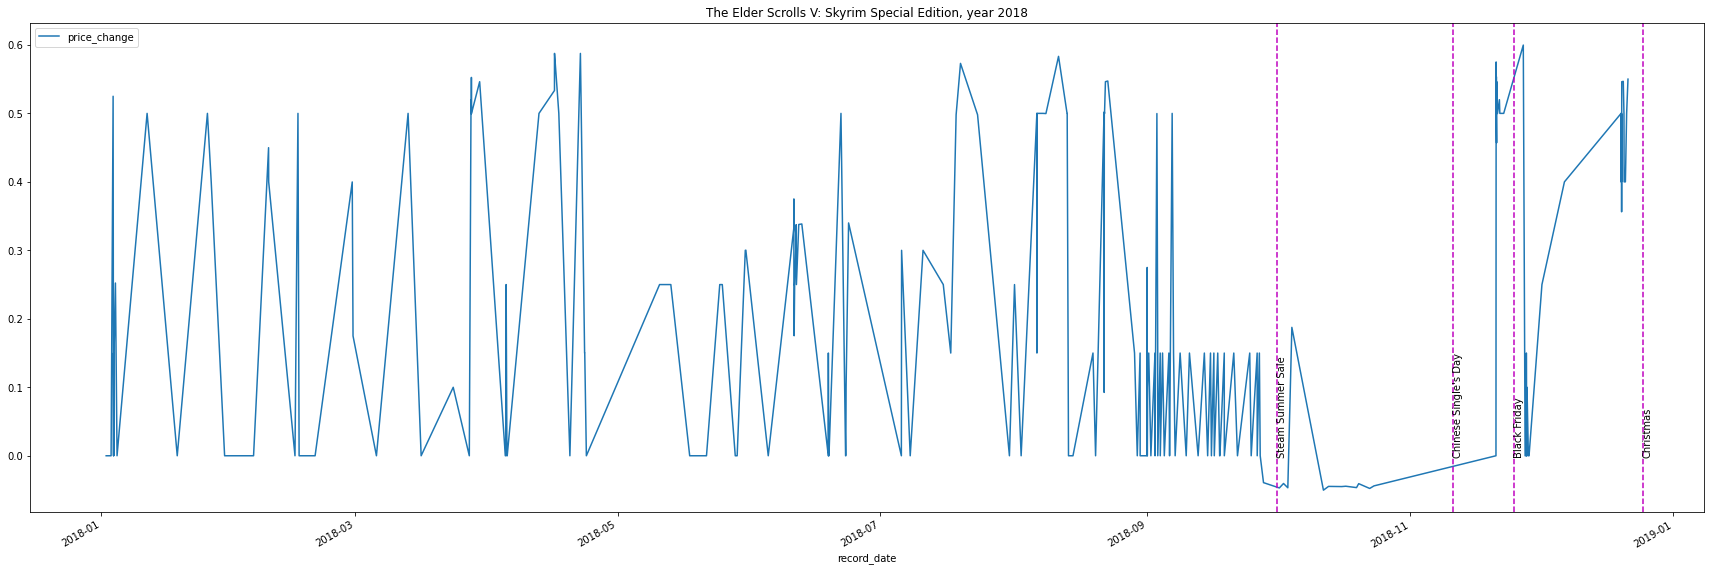

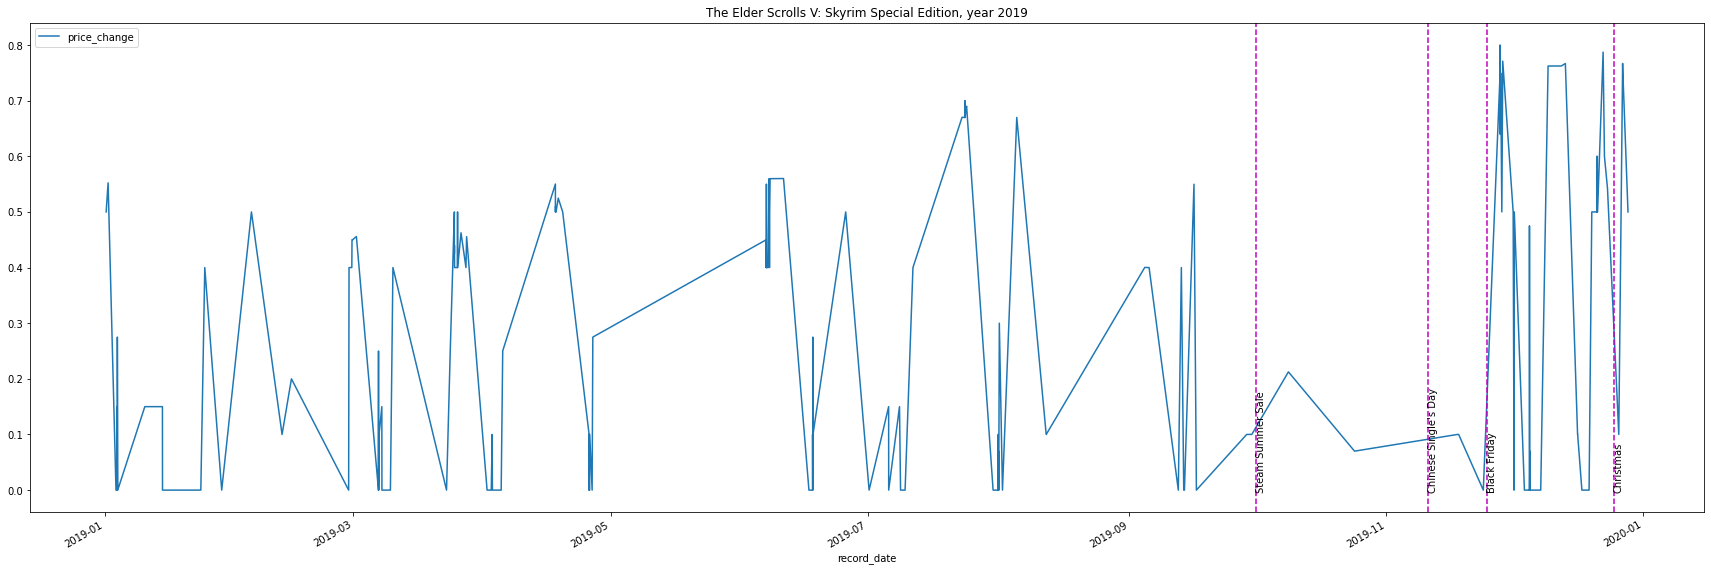

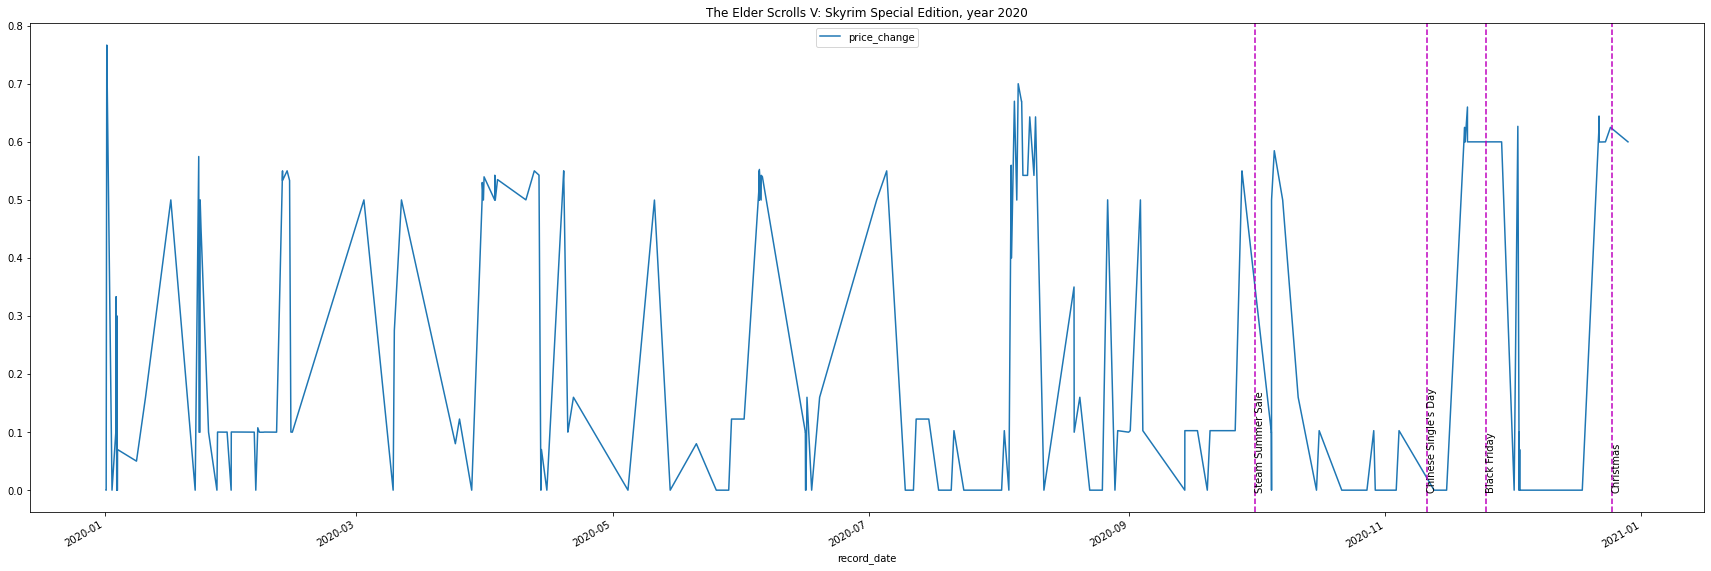

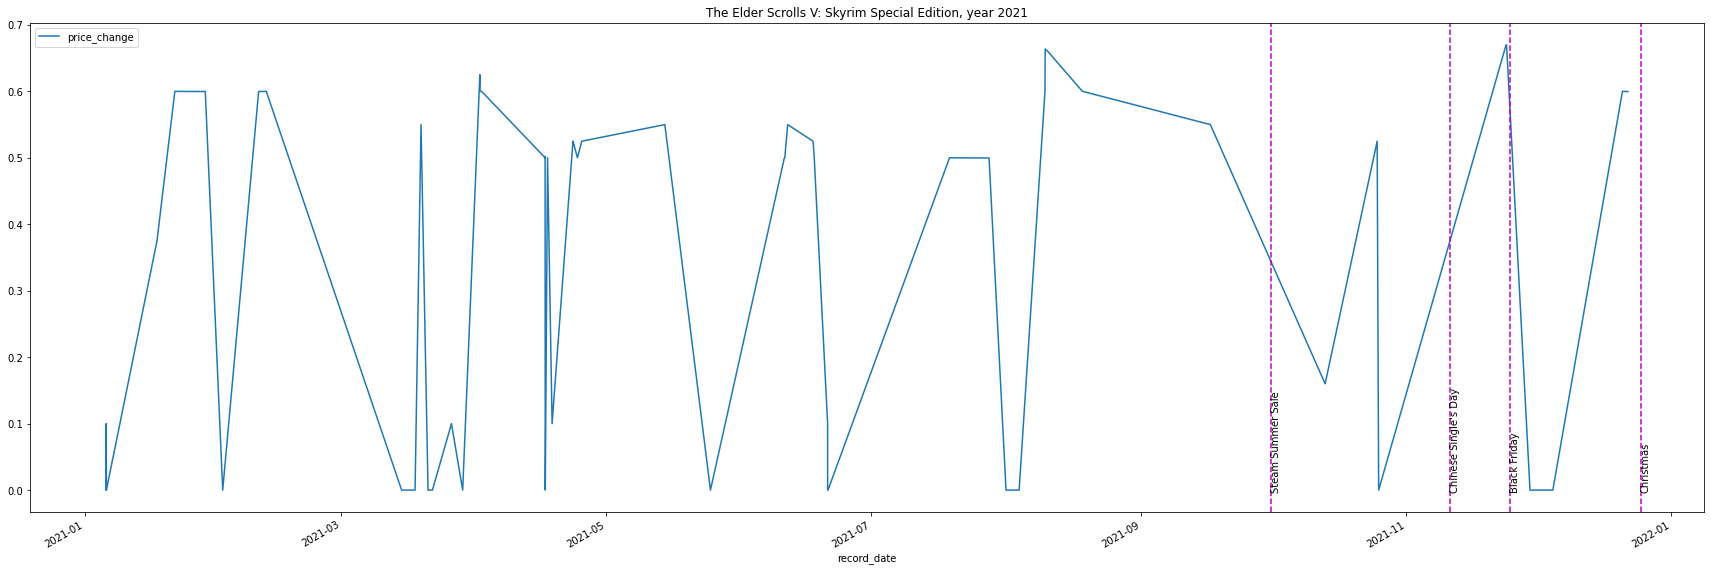

In [54]:
games = get_n_games_row_count(cleaned_games_with_history, 1)
years = list(map(lambda i: i+2017, range(0, 5)))
for (steam_id, game_title, _) in games:
    for year in years:
        plot_game_price_history(cleaned_games_with_history, steam_id, game_title=game_title, year=year, show_holidays=True)

<h2>Advanced Analysis and Machine Learning</h2>

<h3>Feature correlation</h3>

C:\Users\elad1\AppData\Local\Temp/ipykernel_27880/2137357080.py:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
C:\Users\elad1\AppData\Local\Temp/ipykernel_27880/2137357080.py:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr,dtype=np.bool)


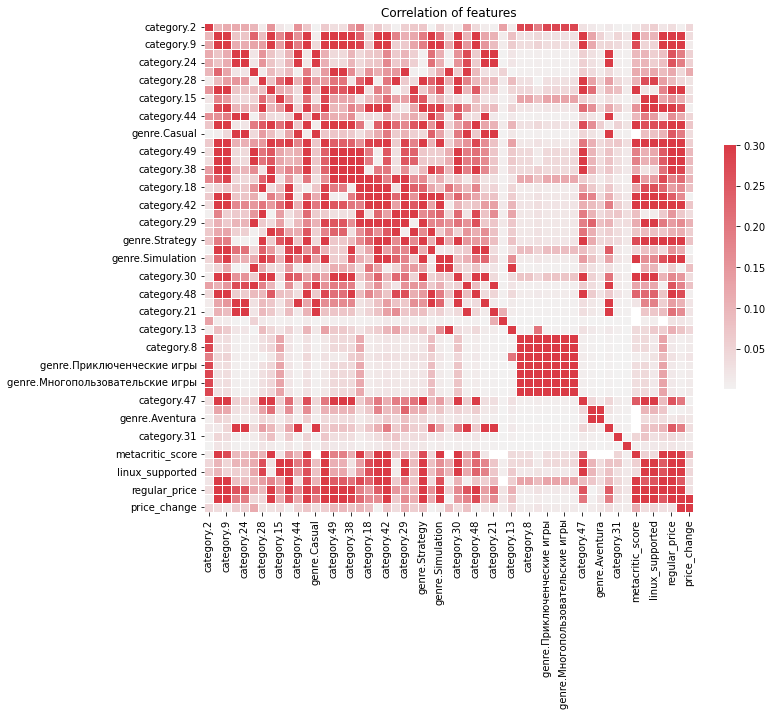

In [99]:
def plot_correlation(ndf: DataFrame):
    df = ndf.copy()
    df = df.loc[:, ~df.columns.str.startswith('supported_language')]
    df = df.loc[:, ~df.columns.str.startswith('publisher')]
    df = df.loc[:, ~df.columns.str.startswith('developer')]
    df.drop(['title', 'windows_supported', 'history_link', 'steamId', 'is_free', 'num_of_dlc', 'number_of_demos', 'num_of_game_videos', 'num_of_packages_game_is_in'], axis=1, inplace=True)
    corr = df.corr().abs()

    upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column] > 0.2)]
    df.drop(to_drop, axis=1, inplace=True)

    mask = np.zeros_like(corr,dtype=np.bool)
    pyplot.subplots(figsize=(11, 9))
    cmap = sns.diverging_palette(220, 10, as_cmap=True)
    sns.heatmap(corr, cmap=cmap, vmax=.3, mask=mask, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5})
    pyplot.title('Correlation of features')

plot_correlation(cleaned_games_with_history)

<h3>Used Resources</h3>
<dl>
    <dt>General</dt>
        <dd><a href="https://pandas.pydata.org/docs/index.html"><b>Pandas Documentation</b></a></dd>
        <dd><a href="https://seaborn.pydata.org"><b>Seaborn Documentation</b></a></dd>
    <dt>Scraping</dt>
        <dd><a href="https://isthereanydeal.com/game/reddeadredemptionii/info/"><b>Is-There-Any-Deal website</b> For scraping cost history and more financial details</a></dd>
        <dd><a href="https://www.geeksforgeeks.org/web-scraping-without-getting-blocked/"><b>Using Proxies to avoiding getting blocked</b></a></dd>
        <dd><a href="https://wiki.teamfortress.com/wiki/User:RJackson/StorefrontAPI#App_info"><b>Steam StoreFront API</b> Limited to 100,000 requests per day, and no more than 10 per second</a></dd>
        <dd><a href="https://store.steampowered.com/api/appdetails">Steam API for Game Metadata - https://store.steampowered.com/api/appdetails?appids=1091500</a></dd>
        <dd><a href="https://www.programiz.com/python-programming/json">Using json serialization and parsing</a></dd>
    <dt>EDA</dt>
        <dd><a href="https://www.laurivan.com/convert-timestamp-to-datetime-for-pandas-dataframe/">Convert timestamp to datetime</a></dd>
    <dt>Stack Overflow</dt>
        <dd><a href="https://stackoverflow.com/questions/613183/how-do-i-sort-a-dictionary-by-value">Sort dictionary by value</a></dd>
        <dd><a href="https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib">Set Figure size</a></dd>
        <dd><a href="https://stackoverflow.com/questions/43822349/drop-column-that-starts-with/43822392">Drop column that starts with</a></dd>
        <dd><a href="https://stackoverflow.com/questions/29294983/how-to-calculate-correlation-between-all-columns-and-remove-highly-correlated-on">Drop all columns which are 95% correlated</a></dd>

</dl>